In [68]:
#Load packages
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

## Description of the approach

### Introduction

The objective of the excise is to forecast the units of 'Total_Orders' in the next 25 weeks/period given the historical data provided. 
It is known that the 'Total_Orders' is subsequently affected by 'Market_Excitation_Orders', 'New_Entrants_Orders' and the 'Frequent_Saver_Orders'. 
The units of the 'Market_Excitation_Orders' and the 'Frequent_Saver_Members' in the next 25 period is also provided, which can possibly used as inputs variables to increase the forecasting accuracy of the 'Total_Orders'.

### EDA and summary

The EDA plots for each variable depicts:
1. there are clearly seasonality and/or trend within all the variables except the 'Market_Excitation_Orders'; 
2. there is large of 0 values in the 'Frequent_saver_Orders' (might due to the data was not collected or data entry error).


The computed correlation coefficient between paired variables and the corresponding pair plot depict that:
1. A strong positive correlation between the 'Frequent_Saver_Members' and the 'Frequent_Saver Orders', which may indicates that the 'Frequent_Saver_Members' can be possibly dropped out if 'Frequent_Saver_Orders' presents in the input list of a predicting model.
2. The 'New_Entrants_Orders' appear negative relation with the 'New_Entrants_Orders' and 'Frequent_Saver_Orders', and 'Twelve_Week_Active_Customers', which may indicates that the marketing strategy to attract to new customers can have negative effect on the purchase intension and loyalty of existing customers. However, its impact on the Total_Order is negligible.

The autocorrelation figure and the partial autocorrelation figure for each variable show that there is moderate/strong autocorrelation existing within each considered variables, which indicates that it coudl be wise to use an AutoRegression model model.

### Model design

The target variable-'Total_Orders', and the predictor variables -'Frequent_Saver Orders' and 'New_Entrants_Orders','Market_Excitation_Orders', can potentially affect each other, i.e. the next step forecast for each variable can be modeled as a linear regression of previous observations of the other variables. (Endogenous).


The other two predictor variables-'Frequent_Saver_Members' and 'Twelve_Week_Active_Customers' can  be treated as the exogenous variables as the impact on  the target is unidirectional. (assumed based on intuition).


Considering the availability of the future data ('Frequent_Saver_Members' is provided), we will use treat the 'Total Orders','New_Entrants_Orders', and 'Market_Excitation_Orders' as endogenous variables and the 'Frequent_Saver_Members' as the exogenous variables as inputs for an Vector Autoregression model. VAR model

#### Pre-processing

The inputs of the VAR model requires stationarity of all the variables whereas the EDA has shown seasonality and trend in certain variable. 

The stationarity of the each variable is tested using a statistical hypothesis test called Augmented Dicky-Fuller test with the null hypothesis that the time series is NOT stationary. Therefore, if the p-value of the test results is large (>0.05), then the time series needs to be transformed to be stationary.  

In this case, each non-stationary time series decomposed to remove the trend and seasonality using the Seasonal and Trend using Loess (STL) method. 
The stationarity of resulted time series are checked again to confirm their suitability to the VAR model in the next step.

The removed trend and seasonality should be added back to the predicted target variables.

#### Modelling and Prediction 

The dataset is split into the train (to train the VAR) and the test (to validate the VAR and select optimal choice of endogenous and exogenous variables)

The train dataset is used to to fit the VAR model. 

The Rooted Mean Square Error is used as the measuring metrics to measure the performance of the model under different combinations of Endogenous and Exogenous variables.

The model that produce the smallest rmse is used to predict the sales of 'Total_Orders' in the next 25 weeks.

## Read in Data

In [2]:
raw_data = pd.read_csv("Sainsburys_Online_Forecasting_Data 2.csv", index_col = 0)

In [3]:
# seperate the held-out data set.
df = raw_data.dropna()
df_heldout = raw_data.iloc[-25:, :]

## Exploratory Data Analysis

### Distribution plot for each variable

It can be seen from the plot that:
1. the total order appears clear trend and seasonality.
2. the market excitation order seems to be random variables. 
3. there is large of 0 values in the frequent saver order (might due to the data was not collected or data entry error). The correlations between each variables shows that:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c055128>,
      dtype=object)

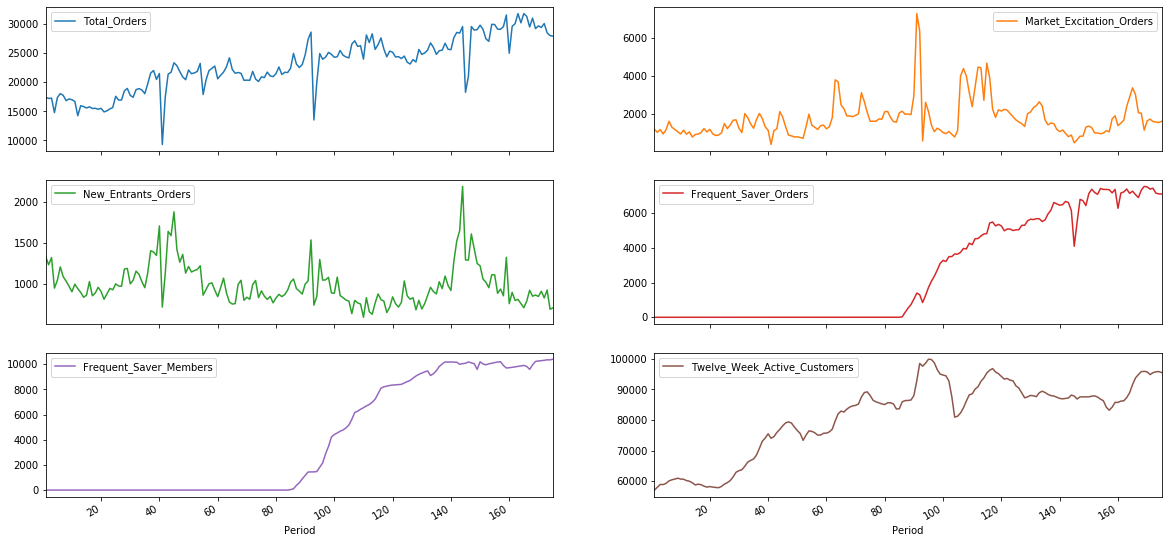

In [69]:
df.plot(subplots =  True, layout = (-1, 2), sharex = True)

### Correlation between variables

In [5]:
df.corr()

,Total_Orders,Market_Excitation_Orders,New_Entrants_Orders,Frequent_Saver_Orders,Frequent_Saver_Members,Twelve_Week_Active_Customers
Total_Orders,1.000000,0.367444,-0.003391,0.826813,0.789375,0.763852
Market_Excitation_Orders,0.367444,1.000000,-0.234757,0.099055,0.090331,0.372698
New_Entrants_Orders,-0.003391,-0.234757,1.000000,-0.146259,-0.140802,-0.192631
Frequent_Saver_Orders,0.826813,0.099055,-0.146259,1.000000,0.991251,0.632920
Frequent_Saver_Members,0.789375,0.090331,-0.140802,0.991251,1.000000,0.626943
Twelve_Week_Active_Customers,0.763852,0.372698,-0.192631,0.632920,0.626943,1.000000


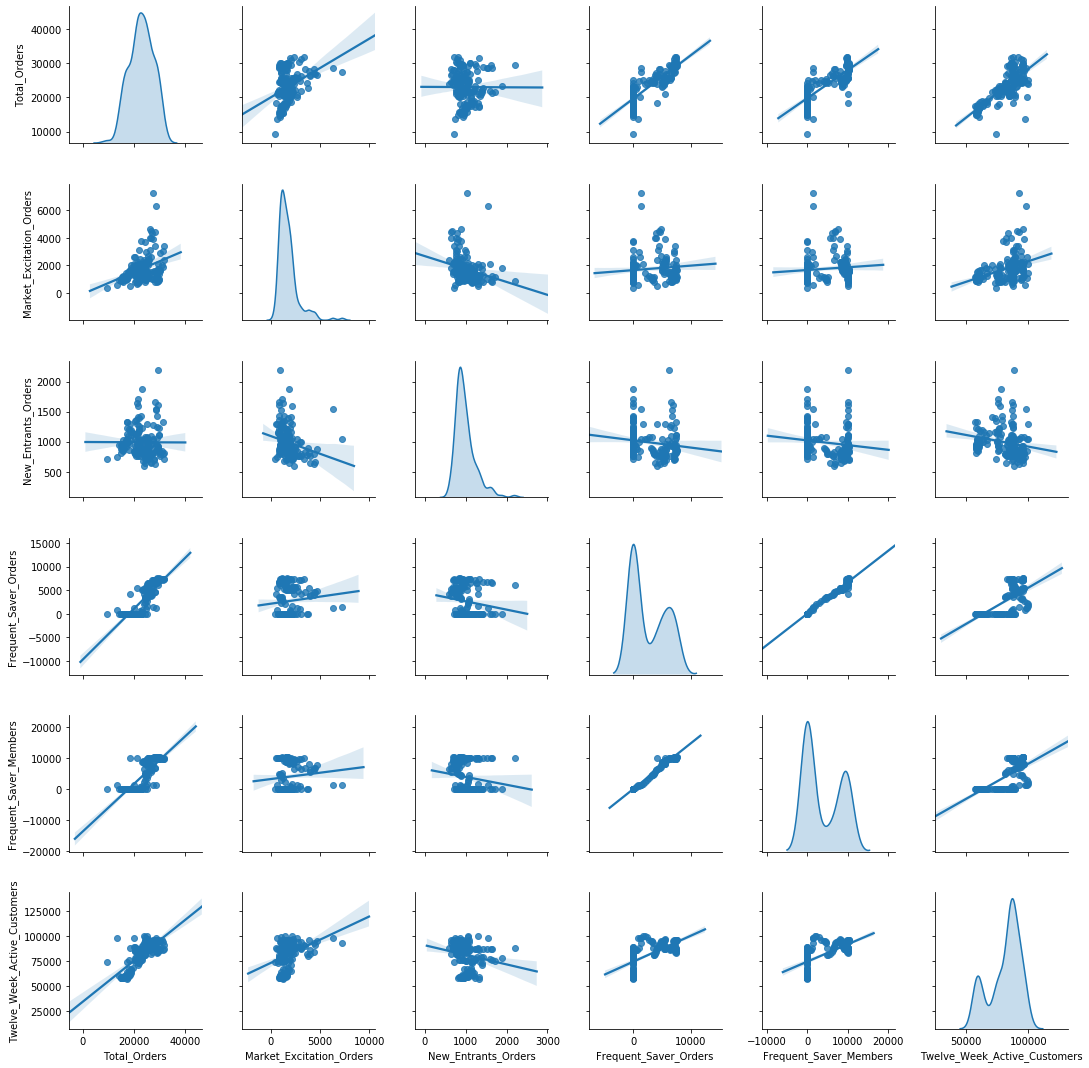

In [6]:
import seaborn as sns
g = sns.pairplot(df, kind="reg", diag_kind="kde")

### Autocorrelations 

In [7]:
def tsplot(y, title, lags=None, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    import statsmodels.api as sm
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    sm.tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    sm.tsa.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax

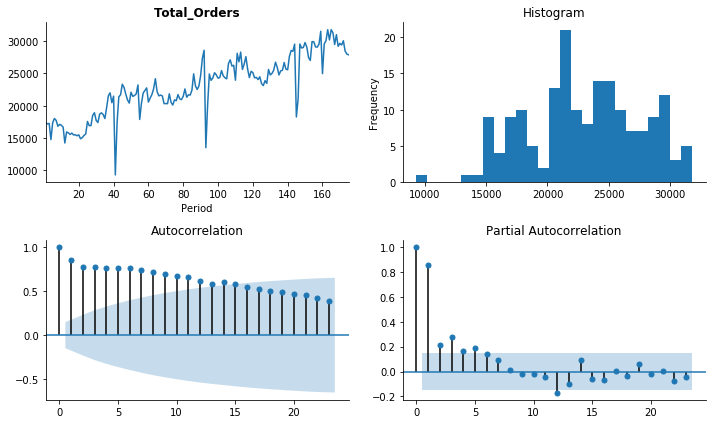

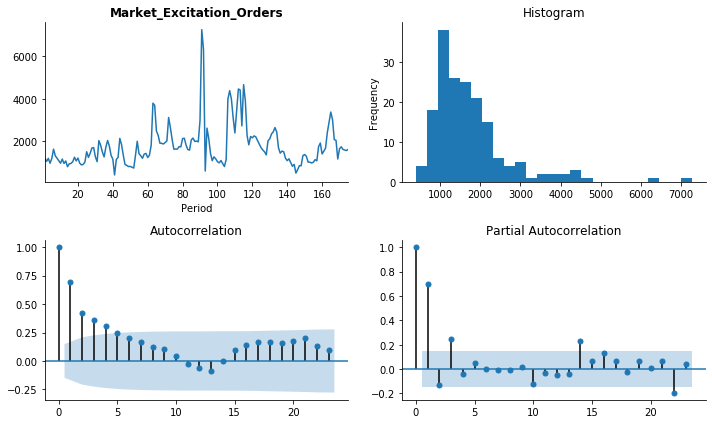

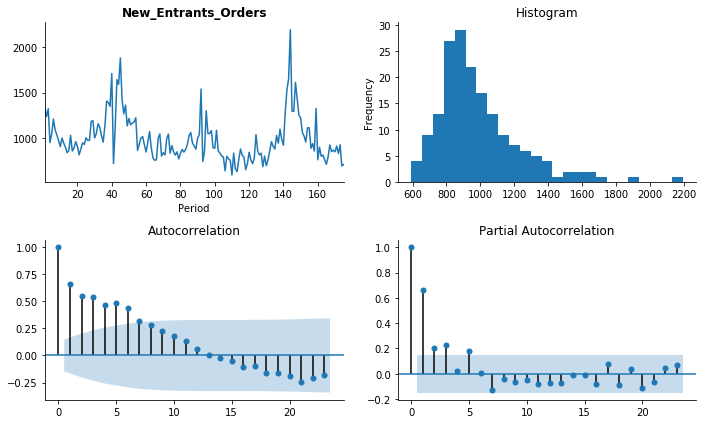

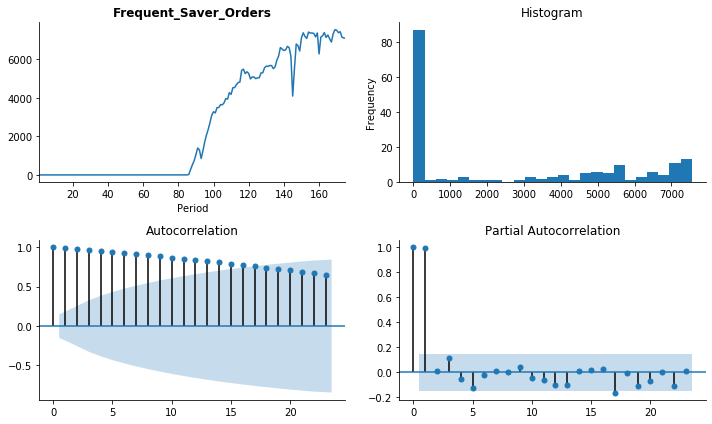

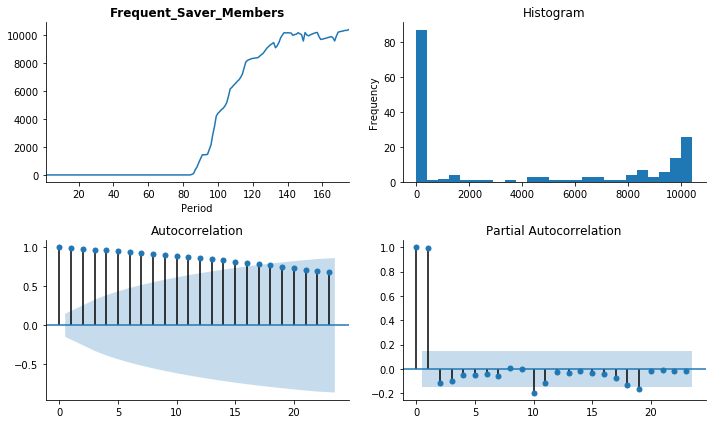

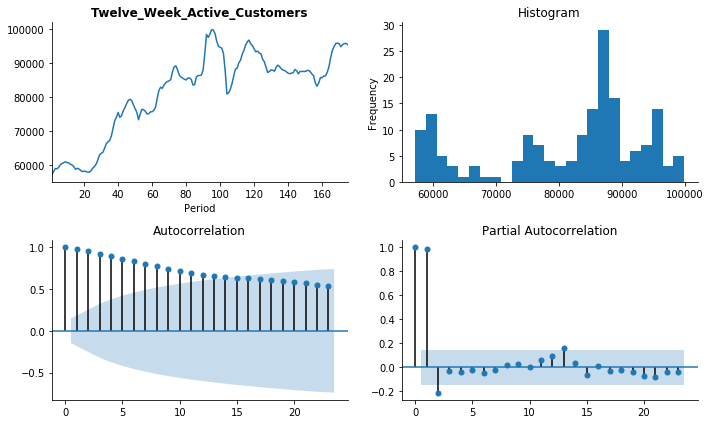

In [8]:
for col in df.columns:
    tsplot(df[col], title = col)

## Modelling

### Preprocessing

In [9]:
df_model = df.drop(['Frequent_Saver_Orders'], axis = 1)
df_model1 = df_model.copy()
df_model.index = pd.date_range(start = '1/1/2015', freq = 'W', periods = len(df_model))

For each column in the df_model, test whehter the time series is stationary, if not, decomponent the time series into trend, seasonality and the error term and keep only the error term as forecasting model input.

#### Make the time series stationary by removing the trend and seasonality

In [10]:
from statsmodels.tsa.stattools import adfuller
import stldecompose

In [11]:
stl_dict = {}
for col in df_model.columns:
    result = adfuller(df_model[col])
    #print('ADF Statistic for {0} is {1}'.format(col, result[0]))
    #print('p-value: %f' % result[1])
    #print('Critical Values:')
    #for key, value in result[4].items():
        #print('The values is {1}: {2}'.format(col, key, value))
    #decompose the time series if it is non-stationary and store the seasonality and trend terms in dictionary
    if result[1]>0.05:  
        stl = stldecompose.decompose(pd.Series(df_model[col]), period = 52)
        stl_dict[col] = stl
        df_model[col] = stl.resid
    #df_model = np.where(result[1]>0.05, decompose(pd.Series(df_model['Total_Orders']), period = 52).resid, df_model[col]

In [12]:
print(np.mean(stl_dict['Total_Orders'].seasonal), np.mean(stl_dict['Total_Orders'].trend), np.mean(stl_dict['Total_Orders'].resid))

48.78185803639756 23140.514377326243 -217.42194964835429


Double check stationarity after decomposition.

In [13]:
for col in df_model.columns:
    result = adfuller(df_model[col])
    print('ADF Statistic for {0} is {1}'.format(col, result[0]))
    print('p-value: %f' % result[1])

ADF Statistic for Total_Orders is -10.045773576389703
p-value: 0.000000
ADF Statistic for Market_Excitation_Orders is -4.145235357175412
p-value: 0.000815
ADF Statistic for New_Entrants_Orders is -5.317154271207659
p-value: 0.000005
ADF Statistic for Frequent_Saver_Members is -3.5239991960439228
p-value: 0.007392
ADF Statistic for Twelve_Week_Active_Customers is -3.6618186570962616
p-value: 0.004683


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f39bd30>,
      dtype=object)

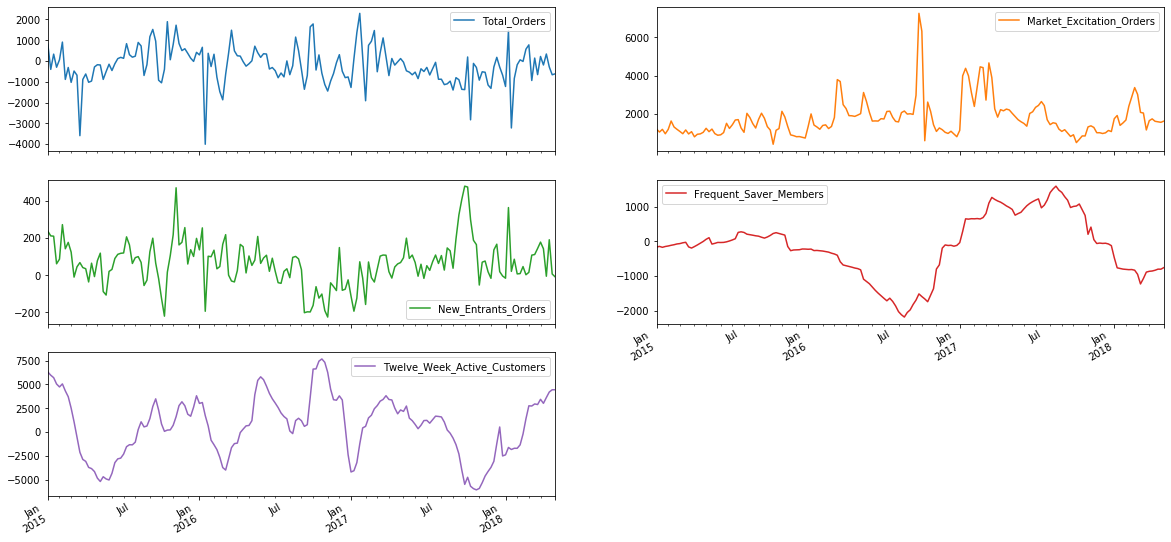

In [70]:
df_model.plot(subplots = True, layout = (-1, 2), sharex =  True)

### Modelling using the Vector AutoRegression Model

Now split the dataset into train and test sets and use a multi-variate time series model to perform the prediction.

In [15]:
train_end = int(0.7*len(df_model))
train = df_model.iloc[: train_end,:]
test = df_model.iloc[train_end+1:,:]

In [16]:
import math
from sklearn.metrics import mean_squared_error, make_scorer

import itertools
from statsmodels.tsa.api import VAR
from stldecompose.forecast_funcs import naive, drift, mean, seasonal_naive

In [17]:
Fix = 'Total_Orders'
endog_list = ['Market_Excitation_Orders', 'New_Entrants_Orders','Frequent_Saver_Members', 
            'Twelve_Week_Active_Customers']
exog_list = ['Market_Excitation_Orders','Frequent_Saver_Members']

In [18]:
all_possible_endog = []
for i in range(1, len(endog_list)+1):
    all_possible_endog.extend([list(x) for x in itertools.combinations(endog_list, i)])

In [19]:
def find_exog_var(exogs, endogs):
        inter = set(endogs).intersection(set(exogs))
        if len(set(exogs) - inter) == 0:
            return None
        else: return list(set(exogs) - inter)

In [20]:
def func_rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

In [21]:
for endog_var in all_possible_endog:
    print (endog_var)

['Market_Excitation_Orders']
['New_Entrants_Orders']
['Frequent_Saver_Members']
['Twelve_Week_Active_Customers']
['Market_Excitation_Orders', 'New_Entrants_Orders']
['Market_Excitation_Orders', 'Frequent_Saver_Members']
['Market_Excitation_Orders', 'Twelve_Week_Active_Customers']
['New_Entrants_Orders', 'Frequent_Saver_Members']
['New_Entrants_Orders', 'Twelve_Week_Active_Customers']
['Frequent_Saver_Members', 'Twelve_Week_Active_Customers']
['Market_Excitation_Orders', 'New_Entrants_Orders', 'Frequent_Saver_Members']
['Market_Excitation_Orders', 'New_Entrants_Orders', 'Twelve_Week_Active_Customers']
['Market_Excitation_Orders', 'Frequent_Saver_Members', 'Twelve_Week_Active_Customers']
['New_Entrants_Orders', 'Frequent_Saver_Members', 'Twelve_Week_Active_Customers']
['Market_Excitation_Orders', 'New_Entrants_Orders', 'Frequent_Saver_Members', 'Twelve_Week_Active_Customers']


In [22]:
def Cross_validation(all_possible_endog):
    min_rmse = np.inf
    for endog_var in all_possible_endog:
        exog_var = find_exog_var(exog_list, endog_var)
        endog_var = ['Total_Orders'] + endog_var
        #print('Endog:', endog_var, 'Exog:', exog_var)

        if exog_var == None:
            model = VAR(endog = train[endog_var])
            best_mdl = model.fit(maxlags=12, ic='bic')
            forecasts = best_mdl.forecast(train[endog_var].values, steps = len(test))
        else: 
            model = VAR(endog = train[endog_var], exog = train[exog_var])
            best_mdl = model.fit(maxlags=12, ic='bic')
            #best_mdl.summary()
            forecasts = best_mdl.forecast(train[endog_var].values, exog_future = test[exog_var].values, 
                                      steps = len(test))

        forecast_total = [forecast[0] for forecast in forecasts] 
        rmse = func_rmse(test['Total_Orders'], forecast_total)
        #print ('The Vector Autoregression model has the rmse of {0}'.format(rmse))
        
        if rmse < min_rmse:
            min_rmse = rmse
            best_combination = [endog_var, exog_var]
            best_model = best_mdl
    return min_rmse , best_combination, best_model

In [23]:
min_rmse , best_combination, best_model = Cross_validation(all_possible_endog)

In [24]:
print(min_rmse, best_combination)

862.1572563233711 [['Total_Orders', 'New_Entrants_Orders'], ['Market_Excitation_Orders', 'Frequent_Saver_Members']]


In [25]:
print(best_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 19, Aug, 2019
Time:                     17:54:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    22.4704
Nobs:                     121.000    HQIC:                   22.3331
Log likelihood:          -1678.86    FPE:                4.55457e+09
AIC:                      22.2393    Det(Omega_mle):     4.20027e+09
--------------------------------------------------------------------
Results for equation Total_Orders
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const      -682.860708       167.152272           -4.085           0.000
exog0         0.363432         0.071690            5.069           0.000
exog1         0.110456         0.090516            1.220           0.222

Results for

## Predict the future values 

In [26]:
def find_exog_future_values(best_combination, stl_dict, df_heldout):
    if len(best_combination) > 1:
        all_exog_future_values = pd.Series()
        for exog in best_combination[1]:
            if exog != 'Market_Excitation_Orders':
                forecast_exog_ts = stldecompose.forecast(stl_dict[exog], 
                                                     steps = 25, fc_func = drift, seasonal = True)
                forecast_exog_ts.index = df_heldout.index
                forecast_exog_ts.rename(columns = {'drift+seasonal': exog}, inplace = True)
                exog_future_value = df_heldout[exog] - forecast_exog_ts[exog]
            else: 
                exog_future_value =  df_heldout[exog] 
                
            all_exog_future_values = pd.concat([all_exog_future_values, exog_future_value], axis = 1)
    return (all_exog_future_values.dropna(axis = 1))

In [27]:
exog_future_value = find_exog_future_values(best_combination, stl_dict, df_heldout)

In [45]:
forecast_endogs = best_model.forecast(best_model.y, steps = 25, 
                                      exog_future = exog_future_value.values)

In [58]:
forecast_future_endog = {}
for i, endog in enumerate(best_combination[0]):
    temp_stl = stldecompose.forecast(stl_dict[endog], steps = 25, fc_func = drift, seasonal = True)
    temp_stl.index = df_heldout.index
    temp_stl.rename(columns = {'drift+seasonal': endog}, inplace = True)
    temp_endog_forecast = forecast_endogs[:,i]
    temp = temp_endog_forecast + temp_stl[endog]
    forecast_future_endog[endog] = temp

In [60]:
print(forecast_future_endog['Total_Orders'])

Period
176    31702.799728
177    31150.317887
178    32545.586310
179    31127.561894
180    32202.907537
181    31512.030078
182    31553.800279
183    32127.228493
184    31228.400114
185    30921.119624
186    31158.406996
187    31339.367871
188    30315.144973
189    30174.020127
190    29774.122381
191    30443.050505
192    29585.061300
193    29646.261907
194    30228.624280
195    29948.784709
196    31692.670636
197    30701.426584
198    30730.365614
199    32174.018072
200    33263.870469
Name: Total_Orders, dtype: float64


Output the target variables

In [64]:
Target_variable = 'Total_Orders'

In [65]:
s = pd.concat([df_model1[Target_variable], forecast_future_endog[Target_variable]], axis = 0)

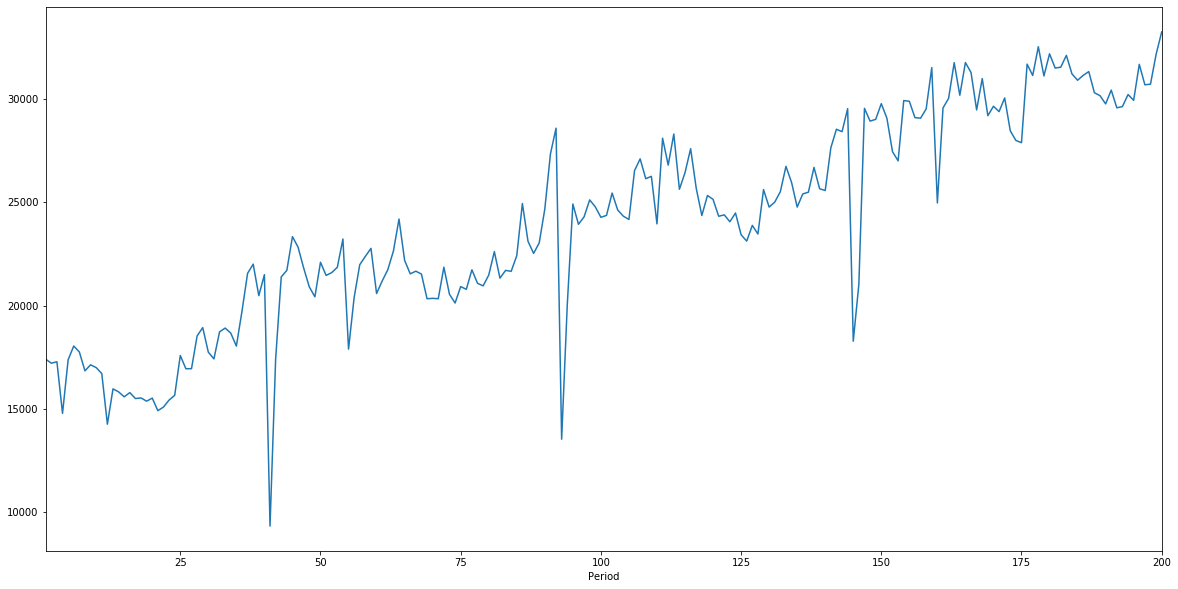

In [71]:
s.plot()

In [67]:
raw_data[Target_variable] = s.values.astype(int)

In [ ]:
raw_data.to_csv("Sainsburys_Online_Forecasting_Data.csv", index = True)